# **Taxi 🚕 Data** 📊
## Loading CSV file. 



In [121]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np



# Define the ZIP file name
zip_file_name = 'Yellow_Taxi_Assignment.csv.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_file:
    # Assuming there is only one CSV file in the ZIP archive
    csv_file_name = zip_file.namelist()[0]
    zip_file.extract(csv_file_name)

# Define the date columns that you want to parse as datetime objects
date_columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# Read the extracted CSV file using pandas with date parsing
df_ny = pd.read_csv(csv_file_name, parse_dates=date_columns)

# Now we can work with the 'df' DataFrame containing the CSV data
# Checking the first few rows:
# Assuming you have a DataFrame named df_ny
##variable_types = df_ny.dtypes

# Now, variable_types is a Series that contains variable names as the index and their data types as values.
# You can print it or iterate over it to see the variable names and their types.
#for variable, data_type in variable_types.items():
#    print(f"Variable: {variable}, Data Type: {data_type}")
df_ny.info()
df_ny.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304978 entries, 0 to 304977
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               304978 non-null  int64         
 1   tpep_pickup_datetime   304978 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  304978 non-null  datetime64[ns]
 3   passenger_count        295465 non-null  float64       
 4   trip_distance          304978 non-null  float64       
 5   RatecodeID             295465 non-null  float64       
 6   store_and_fwd_flag     295465 non-null  object        
 7   PULocationID           304978 non-null  int64         
 8   DOLocationID           304978 non-null  int64         
 9   payment_type           304978 non-null  int64         
 10  fare_amount            304978 non-null  float64       
 11  extra                  304978 non-null  float64       
 12  mta_tax                304978 non-null  floa

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,3.5,0.0,0.5,1.29,0.0,0.3,5.59,NaN,NaN
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,6.0,0.0,0.5,1.02,0.0,0.3,7.82,NaN,NaN
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,9.5,0.5,0.5,1.62,0.0,0.3,12.42,NaN,NaN
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,10.0,0.0,0.5,0.00,0.0,0.3,10.80,NaN,NaN
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,12.5,0.5,0.5,1.00,0.0,0.3,14.80,NaN,NaN


## Data Cleaning & Imputation

We can see from teh Data Frame info that there are 5 columns with null values.  

1.- **We will remove values from the following fields:**
| Field                | Count |
|----------------------|-------|
| passenger_count      | 9513  |
| RatecodeID           | 9513  |
| store_and_fwd_flag   | 9513  |

Because there can not be a Taxi trip without passanger. 

In [122]:
# Remove rows with missing values in specific columns
columns_to_check = ['passenger_count', 'RatecodeID', 'store_and_fwd_flag']
# Dropping the specific values
df_ny.dropna(subset=columns_to_check, inplace=True)
# The new number of rows
print(f"The number of rows is {df_ny.shape[0]}")


The number of rows is 295465


2.- **Nulls in columns `airport_fee` and `congestion_surcharge` I will treat differently.** Now that the rides with no passangers have been remove we will look into columns `airport_fee` and `congestion_surcharge` for cleaning or imputation. The unique values are:

In [123]:
unique_airport_fees = df_ny['airport_fee'].unique()
unique_congestion_surcharges = df_ny['congestion_surcharge'].unique()

print("Unique values in 'airport_fee':")
print(unique_airport_fees)

print("\nUnique values in 'congestion_surcharge':")
print(unique_congestion_surcharges)

Unique values in 'airport_fee':
[  nan  0.    1.25 -1.25]

Unique values in 'congestion_surcharge':
[  nan  0.    2.5  -2.5   2.75  0.5 ]


This are the definitions comming from the db explanations. 

| `airport_fee` : $1.25 for pick up only at LaGuardia and John F. Kennedy Airports. | 
----
| **`congestion_surcharge` : Total amount collected in trip for NYS congestion surcharge.**| 



Following the definitions I will change the negative values to positive and replace the nan for 0. values.
when `airport_fee` is negative then multiply for -1. if `airport_fee` is nan remplace by 0. 

In [124]:
# First, fill NaN values in 'airport_fee' with 0
df_ny['airport_fee'].fillna(0, inplace=True)
df_ny['congestion_surcharge'].fillna(0, inplace=True)
# Then, replace negative values in 'airport_fee' with their absolute values
df_ny['airport_fee'] = df_ny['airport_fee'].apply(lambda x: abs(x) if x < 0 else x)
df_ny['congestion_surcharge'] = df_ny['congestion_surcharge'].apply(lambda x: abs(x) if x < 0 else x)

unique_airport_fees = df_ny['airport_fee'].unique()
unique_congestion_surcharges = df_ny['congestion_surcharge'].unique()

print("Unique values in 'airport_fee':")
print(unique_airport_fees)

print("\nUnique values in 'congestion_surcharge':")
print(unique_congestion_surcharges)

print(f"The number of rows is {df_ny.shape[0]}")

Unique values in 'airport_fee':
[0.   1.25]

Unique values in 'congestion_surcharge':
[0.   2.5  2.75 0.5 ]
The number of rows is 295465


Now all values are fitting the description in the data dictionary pdf. 

## Feature Engeneering  

Creating variable of trip duration in seconds because of its a granularity

In [125]:
df_ny["trip_duration_seconds"] = (df_ny["tpep_dropoff_datetime"] - df_ny["tpep_pickup_datetime"]).astype('timedelta64[s]')

Creating Daytime flag

In [126]:
#Creating flag with daytime 
df_ny['daytime_flag'] = (df_ny["tpep_pickup_datetime"].dt.hour > 5) & (df_ny["tpep_pickup_datetime"].dt.hour < 18)
df_ny['daytime_flag'] = pd.Categorical(df_ny['daytime_flag'])

Creating a Categorical Value for Day of the Week 

In [127]:
# Creating Ctegorical Variable with day of the week. 
df_ny["pickup_weekday"] = df_ny["tpep_pickup_datetime"].dt.dayofweek
df_ny["pickup_weekday"] = pd.Categorical(df_ny["pickup_weekday"] )

Creatring varaibles Month to form time series. 

In [128]:
df_ny["month_of_trip"] = df_ny["tpep_pickup_datetime"].dt.strftime('%b-%y')


In [129]:
# Creating number of rides per month 


The new db looks like this:

In [130]:
df_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 295465 entries, 0 to 304977
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               295465 non-null  int64         
 1   tpep_pickup_datetime   295465 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  295465 non-null  datetime64[ns]
 3   passenger_count        295465 non-null  float64       
 4   trip_distance          295465 non-null  float64       
 5   RatecodeID             295465 non-null  float64       
 6   store_and_fwd_flag     295465 non-null  object        
 7   PULocationID           295465 non-null  int64         
 8   DOLocationID           295465 non-null  int64         
 9   payment_type           295465 non-null  int64         
 10  fare_amount            295465 non-null  float64       
 11  extra                  295465 non-null  float64       
 12  mta_tax                295465 non-null  float64  

The final table is looking like this:

In [131]:
df_ny.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,daytime_flag,pickup_weekday,month_of_trip
0,2,2018-01-01 12:02:01,2018-01-01 12:04:05,1.0,0.53,1.0,N,142,163,1,...,1.29,0.0,0.3,5.59,0.0,0.0,0 days 00:02:04,True,0,Jan-18
1,2,2018-01-01 12:26:48,2018-01-01 12:31:29,1.0,1.05,1.0,N,140,236,1,...,1.02,0.0,0.3,7.82,0.0,0.0,0 days 00:04:41,True,0,Jan-18
2,2,2018-01-01 01:28:34,2018-01-01 01:39:38,4.0,1.83,1.0,N,211,158,1,...,1.62,0.0,0.3,12.42,0.0,0.0,0 days 00:11:04,False,0,Jan-18
3,1,2018-01-01 08:51:59,2018-01-01 09:01:45,1.0,2.30,1.0,N,249,4,2,...,0.00,0.0,0.3,10.80,0.0,0.0,0 days 00:09:46,True,0,Jan-18
4,2,2018-01-01 01:00:19,2018-01-01 01:14:16,1.0,3.06,1.0,N,186,142,1,...,1.00,0.0,0.3,14.80,0.0,0.0,0 days 00:13:57,False,0,Jan-18


## Exploratory Data Analysis. 
In this section I try to give a "Forest" view of the data. I will show two most important time series describing the data. The number of passangers and the overall amount payed. 


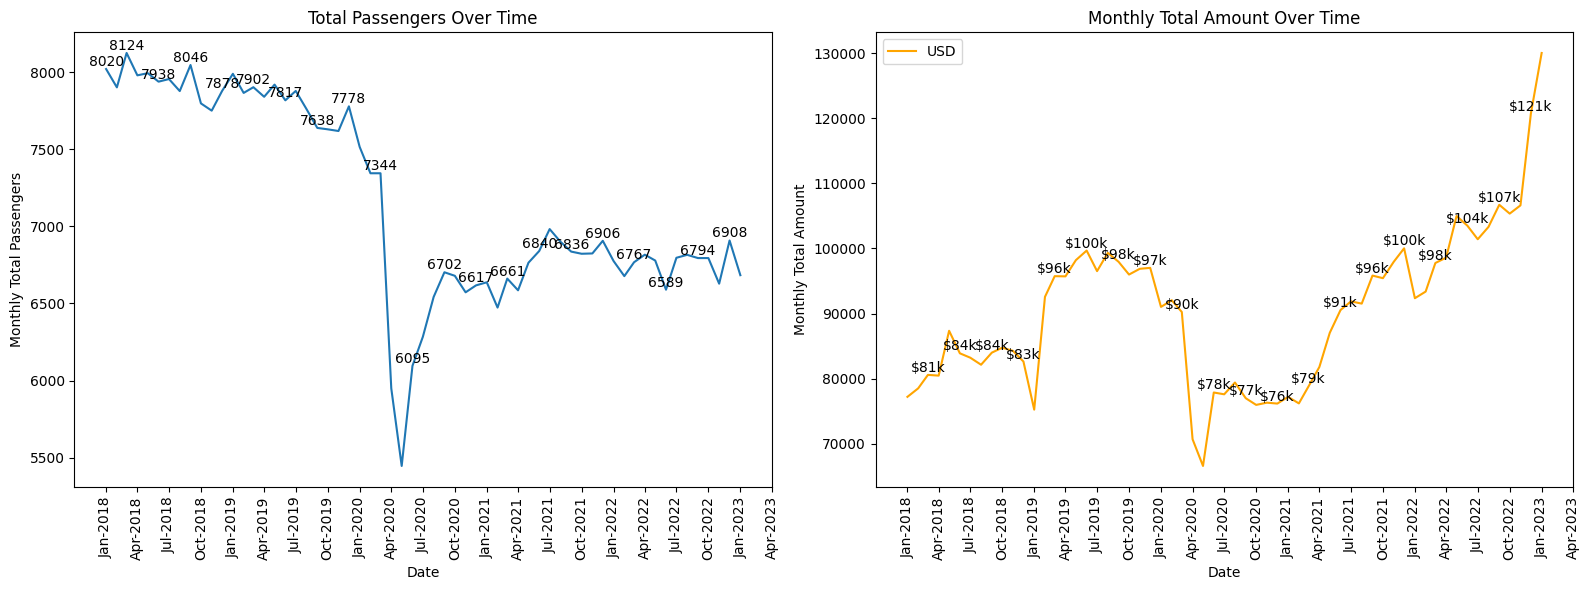

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by the formatted_pickup_date and sum the passenger_count
monthly_passenger_count = df_ny.groupby('month_of_trip')['passenger_count'].sum().reset_index()
monthly_passenger_count['month_of_trip'] = pd.to_datetime(monthly_passenger_count['month_of_trip'], format='%b-%y')
monthly_passenger_count.sort_values(by='month_of_trip', inplace=True)

# Group by the formatted_pickup_date and sum the total_amount
monthly_amount = df_ny.groupby('month_of_trip')['total_amount'].sum().reset_index()
monthly_amount['month_of_trip'] = pd.to_datetime(monthly_amount['month_of_trip'], format='%b-%y')
monthly_amount.sort_values(by='month_of_trip', inplace=True)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the passenger count data in the first subplot
axs[0].plot(monthly_passenger_count['month_of_trip'], monthly_passenger_count['passenger_count'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Monthly Total Passengers')
axs[0].set_title('Total Passengers Over Time')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[0].tick_params(axis='x', rotation=90)


# Annotate data points with number labels at 3-month intervals and the first month
for x, y in zip(monthly_passenger_count['month_of_trip'], monthly_passenger_count['passenger_count']):
    if x.month % 3 == 0 or (x.month == 1 and x.year == 2018):
        axs[0].text(x, y, f'{int(y)}', ha='center', va='bottom')

# Plot the total amount data in the second subplot
axs[1].plot(monthly_amount['month_of_trip'], monthly_amount['total_amount'], label='USD', color='orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Monthly Total Amount')
axs[1].set_title('Monthly Total Amount Over Time')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs[1].tick_params(axis='x', rotation=90)

# Annotate data points with number labels at 3-month intervals
for x, y in zip(monthly_amount['month_of_trip'], monthly_amount['total_amount']):
    if x.month % 3 == 0:
        axs[1].text(x, y, f'${y/1000:.0f}k', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.legend()
plt.show()


The passenger count data demonstrates a consistent and substantial decline in ridership, with an estimated -15% decrease from early 2018 to 2023. Notably, the dataset highlights a significant drop in passenger numbers during the COVID-19 pandemic, underscoring the pandemic's profound impact on transportation, resulting in the lowest ridership levels. The amount payed nontheless shows a steap increase. Which generates more questions regarding how is this increase possible. 

Does the distance increased over time or the amount of time spent in the taxi increased over time ? 

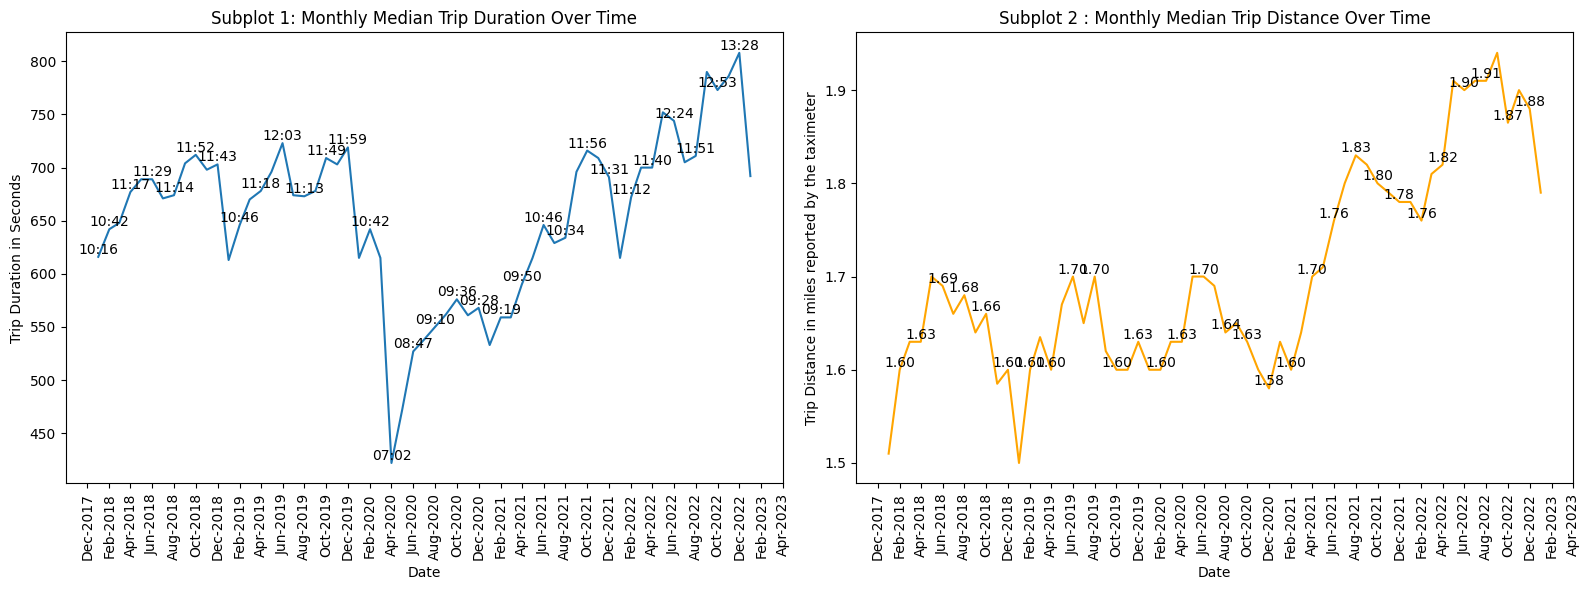

In [139]:
avg_monthly_trip_duration = df_ny.groupby('month_of_trip')['trip_duration_seconds'].median().reset_index()
avg_monthly_trip_duration['month_of_trip'] = pd.to_datetime(avg_monthly_trip_duration['month_of_trip'], format='%b-%y')
avg_monthly_trip_duration.sort_values(by='month_of_trip', inplace=True)


avg_monthly_distance = df_ny.groupby('month_of_trip')['trip_distance'].median().reset_index()
avg_monthly_distance['month_of_trip'] = pd.to_datetime(avg_monthly_distance['month_of_trip'], format='%b-%y')
avg_monthly_distance.sort_values(by='month_of_trip', inplace=True)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(avg_monthly_trip_duration['month_of_trip'], avg_monthly_trip_duration['trip_duration_seconds'])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Trip Duration in Seconds')
axs[0].set_title('Subplot 1: Monthly Median Trip Duration Over Time')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[0].tick_params(axis='x', rotation=90)

# Annotate data points with labels in minutes:seconds format at 3-month intervals and the first month
for x, y in zip(avg_monthly_trip_duration['month_of_trip'], avg_monthly_trip_duration['trip_duration_seconds']):
    if x.month % 2 == 0 or (x.month == 1 and x.year == 2018):
        total_seconds = int(y.total_seconds())
        minutes = total_seconds // 60
        seconds = total_seconds % 60
        annotation_text = f'{minutes:02d}:{seconds:02d}'  # Format as mm:ss
        axs[0].text(x, y.total_seconds(), annotation_text, ha='center', va='bottom')

axs[1].plot(avg_monthly_distance['month_of_trip'], avg_monthly_distance['trip_distance'],color='orange')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Trip Distance in miles reported by the taximeter')
axs[1].set_title('Subplot 2 : Monthly Median Trip Distance Over Time')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
axs[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axs[1].tick_params(axis='x', rotation=90)

# Annotate data points with number labels at 3-month intervals
for x, y in zip(avg_monthly_distance['month_of_trip'], avg_monthly_distance['trip_distance']):
    if x.month % 2 == 0:
        axs[1].text(x, y, f'{y:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()



From 01.01.2018 untill 31.01.2023 there is an increase in the avarage distance per ride in 19% from 2.80 to 3.40. This increase is not as clear in the trip duration

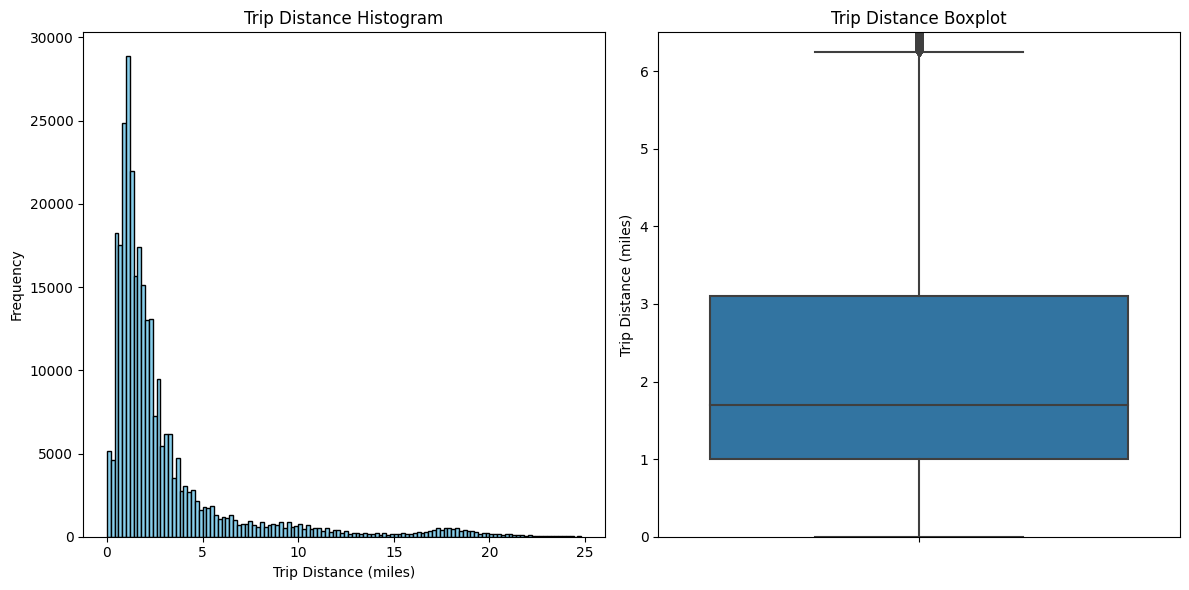

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame df_ny with a "trip_distance" column
trip_distance = df_ny["trip_distance"]

# Create a figure with two subplots: one for the histogram and one for the boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create a histogram
ax1.hist(trip_distance, bins=np.arange(0, 25, 0.2), color='skyblue', edgecolor='black')

# Set labels and title for the histogram
ax1.set_xlabel('Trip Distance (miles)')
ax1.set_ylabel('Frequency')
ax1.set_title('Trip Distance Histogram')

# Create a boxplot
sns.boxplot(y=trip_distance, ax=ax2)
ax2.set_ylim(0, 6.5)
# Set labels and title for the boxplot
ax2.set_ylabel('Trip Distance (miles)')
ax2.set_title('Trip Distance Boxplot')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


### References and Resources:
*Many features were extracted from Chat GPT or the following repository in github*:
https://github.com/norberte/DS_professional_development/blob/master/DS%20interviews/NYC%20Yellow%20Taxi.ipynb

Time series CPI from :
https://fred.stlouisfed.org/series/CPIAUCSL#0